In [2]:
import pandas as pd
import numpy as np
import requests
import json
from flatten_json import flatten
import itertools
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
sns.set(rc = {'figure.figsize':(15,8)})
pd.options.mode.chained_assignment = None

# Importing the Data

I will start by importing our data through API calls to teleport.org. I will pull data on quality of life and salary for nine Canadian cities (listed in the variable: 'canadian_cities')

In [3]:
sample_url = 'https://api.teleport.org/api/urban_areas/slug:ottawa/scores/'
base_url = 'https://api.teleport.org/api/urban_areas/slug:'

In [4]:
canadian_cities = ['ottawa','halifax','quebec','toronto','winnipeg','edmonton','victoria','montreal','vancouver']

In [5]:
def pull_score(cities): 
    raw_data = pd.DataFrame()
    for city in cities:
        results_jsons = requests.get(base_url + city + '/scores/').json()
        results_list = [result_json for result_json in results_jsons['categories']]
        results_df = pd.DataFrame(results_list)
        results_df.insert(0,'City',city)
        raw_data = pd.concat([raw_data,results_df])
    return raw_data

In [6]:
def pull_salaries(cities):
    raw_data = pd.DataFrame()
    for city in cities:
        results_jsons = requests.get(base_url + city + '/salaries/').json()
        results_list = [result_json for result_json in results_jsons['salaries']]
        results_df = pd.DataFrame(results_list)
        results_df.insert(0,'City',city)
        raw_data = pd.concat([raw_data,results_df])
    return raw_data

In [7]:
def clean_details(df):
    #Used to preprocess the data gathered through the pull_details function. 
    #Entries are pulled as heavily nested JSON objects and are then normalized with the json_normalize function
    data = []
    for i in range(len(df.values)-1):
        temp = pd.json_normalize(df.values[i])
        data.append(temp)
    df = pd.concat(data)
    return df

In [8]:
def pull_details(cities):
    raw_data = pd.DataFrame()
    for city in cities:
        results_jsons = requests.get(base_url + city + '/details/').json()
        results_list = [result_json for result_json in results_jsons['categories']]
        results_list = pd.json_normalize(results_list)
        results_df = pd.DataFrame(results_list)
        results_df = clean_details(results_df['data'])
        results_df.insert(0,'City',city)
        raw_data = pd.concat([raw_data,results_df])
    return raw_data

In [9]:
data_score = pull_score(canadian_cities)
data_salaries = pull_salaries(canadian_cities)
data_details = pull_details(canadian_cities)

In [10]:
file_score = data_score.to_csv('data_score.csv')
file_salaries = data_salaries.to_csv('data_salaries.csv')
file_details = data_details.to_csv('data_details.csv')

In [11]:
raw_score = pd.read_csv('data_score.csv',index_col = 0)
raw_salaries = pd.read_csv('data_salaries.csv',index_col = 0)
raw_details = pd.read_csv('data_details.csv',index_col = 0)

# Cleaning the Data

I'll start by dropping unused columns and converting the quality of life scores to numeric. Otherwise, very little needs to be done to clean the raw_score dataframe.

In [12]:
raw_score_preprocessed = raw_score.drop(['color'],axis = 1)
raw_score_preprocessed['score_out_of_10'] = pd.to_numeric(raw_score_preprocessed['score_out_of_10']).round(2)
raw_score_preprocessed

,City,name,score_out_of_10
0,ottawa,Housing,6.70
1,ottawa,Cost of Living,6.03
2,ottawa,Startups,6.06
3,ottawa,Venture Capital,2.61
4,ottawa,Travel Connectivity,1.53
...,...,...,...
12,vancouver,Taxation,7.27
13,vancouver,Internet Access,4.55
14,vancouver,Leisure & Culture,5.72
15,vancouver,Tolerance,8.30


In contrast, the raw_salaries data frame requires extensive cleaning to be usable for analysis.

In [13]:
raw_salaries.head()

,City,job,salary_percentiles
0,ottawa,"{'id': 'ACCOUNT-MANAGER', 'title': 'Account Ma...","{'percentile_25': 38347.05439050182, 'percenti..."
1,ottawa,"{'id': 'ACCOUNTANT', 'title': 'Accountant'}","{'percentile_25': 36693.18082147674, 'percenti..."
2,ottawa,"{'id': 'ADMINISTRATIVE-ASSISTANT', 'title': 'A...","{'percentile_25': 24060.5785393322, 'percentil..."
3,ottawa,"{'id': 'ARCHITECT', 'title': 'Architect'}","{'percentile_25': 33183.27362218917, 'percenti..."
4,ottawa,"{'id': 'ATTORNEY', 'title': 'Attorney'}","{'percentile_25': 48563.083746339544, 'percent..."


Job Title can be extracted by splitting the job column on the comma delimiter and stripping away the label and other unnecessary characters.

In [14]:
raw_salaries_job = raw_salaries['job'].str.split(',',expand = True).drop([0],axis = 1)
raw_salaries_job
raw_salaries['job_title'] = raw_salaries_job[1].str.lstrip("'title': '").str.rstrip("'}'")
raw_salaries

,City,job,salary_percentiles,job_title
0,ottawa,"{'id': 'ACCOUNT-MANAGER', 'title': 'Account Ma...","{'percentile_25': 38347.05439050182, 'percenti...",Account Manager
1,ottawa,"{'id': 'ACCOUNTANT', 'title': 'Accountant'}","{'percentile_25': 36693.18082147674, 'percenti...",Accountant
2,ottawa,"{'id': 'ADMINISTRATIVE-ASSISTANT', 'title': 'A...","{'percentile_25': 24060.5785393322, 'percentil...",Administrative Assistant
3,ottawa,"{'id': 'ARCHITECT', 'title': 'Architect'}","{'percentile_25': 33183.27362218917, 'percenti...",Architect
4,ottawa,"{'id': 'ATTORNEY', 'title': 'Attorney'}","{'percentile_25': 48563.083746339544, 'percent...",Attorney
...,...,...,...,...
47,vancouver,"{'id': 'TEACHER', 'title': 'Teacher'}","{'percentile_25': 28986.42218258517, 'percenti...",Teacher
48,vancouver,"{'id': 'UX-DESIGNER', 'title': 'UX Designer'}","{'percentile_25': 42649.77670287489, 'percenti...",UX Designer
49,vancouver,"{'id': 'WAITER', 'title': 'Waiter'}","{'percentile_25': 17295.127257677457, 'percent...",Waiter
50,vancouver,"{'id': 'WEB-DESIGNER', 'title': 'Web Designer'}","{'percentile_25': 35350.745537308176, 'percent...",Web Designer


Similarly, I can split the salary_percentiles column on the comma to get the 25th, 50th, and 75th percentile salaries for each job title.

In [15]:
raw_salaries_percentiles = raw_salaries['salary_percentiles'].str.split(',', expand = True)
raw_salaries_percentiles[0] = raw_salaries_percentiles[0].str.lstrip("{'percentile_25': ")
raw_salaries_percentiles[1] = raw_salaries_percentiles[1].str.lstrip("'percentile_50': ")
raw_salaries_percentiles[2] = raw_salaries_percentiles[2].str.lstrip("'percentile_75': ").str.rstrip("}")
raw_salaries_names = dict({0:'percentile_25',1:'percentile_50',2:'percentile_75'})
raw_salaries_percentiles.rename(columns=raw_salaries_names,inplace = True)
raw_salaries = pd.concat([raw_salaries,raw_salaries_percentiles],axis = 1)
raw_salaries = raw_salaries.drop(['job','salary_percentiles'],axis = 1)
raw_salaries[['percentile_25','percentile_50','percentile_75']] = raw_salaries[['percentile_25','percentile_50','percentile_75']].astype(float).round(2)
raw_salaries_preprocessed = raw_salaries
raw_salaries_preprocessed

,City,job_title,percentile_25,percentile_50,percentile_75
0,ottawa,Account Manager,38347.05,46742.15,6975.14
1,ottawa,Accountant,36693.18,43603.26,1814.64
2,ottawa,Administrative Assistant,4060.58,28197.41,33045.51
3,ottawa,Architect,33183.27,40676.64,49862.15
4,ottawa,Attorney,48563.08,63391.54,82747.78
...,...,...,...,...,...
47,vancouver,Teacher,8986.42,37889.11,49526.11
48,vancouver,UX Designer,42649.78,1085.02,61188.58
49,vancouver,Waiter,17295.13,23534.06,32023.59
50,vancouver,Web Designer,35350.75,41957.26,49798.43


The majority of preprocessing work for the raw_details data frame was done during our intial import of the data using json_normalize and the 'clean_details' function.

In [16]:
raw_details.head()
raw_details_preprocessed = raw_details
raw_details_preprocessed

,City,float_value,id,label,type,percent_value,string_value,currency_dollar_value,int_value,url_value
0,ottawa,81.8000,BUSINESS-FREEDOM,Business freedom,float,NaN,NaN,NaN,NaN,NaN
1,ottawa,0.8027,BUSINESS-FREEDOM-TELESCORE,Business freedom [Teleport score],float,NaN,NaN,NaN,NaN,NaN
2,ottawa,81.0000,CORRUPTION-FREEDOM,Freedom from corruption,float,NaN,NaN,NaN,NaN,NaN
3,ottawa,0.8871,CORRUPTION-FREEDOM-TELESCORE,Freedom from corruption [Teleport score],float,NaN,NaN,NaN,NaN,NaN
4,ottawa,72.6000,LABOR-RESTRICTIONS,Lack of labor restrictions,float,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
0,vancouver,NaN,HUMAN-CITIES-PAGE-URLS,Human city page,url,NaN,NaN,NaN,NaN,http://cities.human.co/details/Canada/Vancouver
1,vancouver,0.5748,TRAFFIC-INDEX-TELESCORE,Traffic handling [Teleport score],float,NaN,NaN,NaN,NaN,NaN
0,vancouver,NaN,AIRPORT-HUB-INDEX-DETAIL,Airport hub,int,NaN,NaN,NaN,86.0,NaN
1,vancouver,0.4155,AIRPORT-HUB-TELESCORE,Airport hub [Teleport score],float,NaN,NaN,NaN,NaN,NaN


In [17]:
ind = range(len(canadian_cities))
city_dict = dict(zip(ind,canadian_cities))
city_data = pd.DataFrame.from_dict(city_dict, orient = 'index')
city_data = city_data.rename(columns = {0:'city'})
city_data

,city
0,ottawa
1,halifax
2,quebec
3,toronto
4,winnipeg
5,edmonton
6,victoria
7,montreal
8,vancouver


# Formulating Our Questions

In [18]:
#raw_score_preprocessed
#raw_salaries_preprocessed
#raw_details_preprocessed

display(raw_score_preprocessed.describe(include='all'),
        raw_salaries_preprocessed.describe(include = 'all'),
        raw_details_preprocessed.describe(include = 'all'))

,City,name,score_out_of_10
count,153,153,153.000000
unique,9,17,NaN
top,ottawa,Housing,NaN
freq,17,9,NaN
mean,NaN,NaN,6.152941
std,NaN,NaN,2.060300
min,NaN,NaN,0.000000
25%,NaN,NaN,4.940000
50%,NaN,NaN,5.950000
75%,NaN,NaN,7.810000


,City,job_title,percentile_25,percentile_50,percentile_75
count,468,468,468.000000,468.000000,468.000000
unique,9,52,NaN,NaN,NaN
top,ottawa,Account Manager,NaN,NaN,NaN
freq,52,9,NaN,NaN,NaN
mean,NaN,NaN,30881.227372,36938.969038,41331.708632
std,NaN,NaN,20360.348385,26169.866879,36999.981805
min,NaN,NaN,3.460000,0.400000,32.770000
25%,NaN,NaN,8843.430000,20428.875000,4740.545000
50%,NaN,NaN,35953.185000,37607.770000,39942.725000
75%,NaN,NaN,42724.087500,46893.210000,62461.122500


,City,float_value,id,label,type,percent_value,string_value,currency_dollar_value,int_value,url_value
count,1356,657.000000,1356,1356,1356,139.000000,144,152.000000,258.000000,6
unique,9,NaN,155,155,6,NaN,37,NaN,NaN,6
top,vancouver,NaN,BUSINESS-FREEDOM,Business freedom,float,NaN,✔ Legal,NaN,NaN,http://cities.human.co/details/Canada/Ottawa
freq,154,NaN,9,9,657,NaN,27,NaN,NaN,1
mean,NaN,102.167448,NaN,NaN,NaN,0.188447,NaN,5602.658408,2859.414457,NaN
std,NaN,577.040711,NaN,NaN,NaN,0.249687,NaN,15379.466694,22310.736757,NaN
min,NaN,0.100000,NaN,NaN,NaN,0.000710,NaN,0.760000,1.000000,NaN
25%,NaN,0.594800,NaN,NaN,NaN,0.026320,NaN,7.925000,9.000000,NaN
50%,NaN,0.843200,NaN,NaN,NaN,0.108948,NaN,62.530000,44.500000,NaN
75%,NaN,9.480000,NaN,NaN,NaN,0.163959,NaN,855.000000,125.500000,NaN


The above summaries provide us with some basic information about the data, with varying degrees of usefulness. 
A few key insights that might serve as a starting point for our analysis:
- We see massive gaps between the lowest and highest values for the 25th, 50th, and 75th percentile salaries. It would           be interesting to plot this data by city and by profession to get more context.
- The mean salaries appear to be consistently higher than the median salaries, meaning there are some larger outliers             pulling the mean up. It would be interesting to identify these outliers and where in the country they occur.
- It would be interesting to see how higher salaries correlate with scores in the various categories.
- It would be interesting to see how scores correlate with one another.

## Examining Salary Percentiles

In [19]:
raw_salaries_preprocessed.head()

,City,job_title,percentile_25,percentile_50,percentile_75
0,ottawa,Account Manager,38347.05,46742.15,6975.14
1,ottawa,Accountant,36693.18,43603.26,1814.64
2,ottawa,Administrative Assistant,4060.58,28197.41,33045.51
3,ottawa,Architect,33183.27,40676.64,49862.15
4,ottawa,Attorney,48563.08,63391.54,82747.78


In [20]:
#Starting by examining median salary by city
mean_salary_city = raw_salaries_preprocessed.groupby(['City'],as_index = False).mean()
mean_salary_city

,City,percentile_25,percentile_50,percentile_75
0,edmonton,30792.221923,38326.348654,46226.444615
1,halifax,30150.696346,36273.982885,36045.230385
2,montreal,27256.631731,34293.209615,41105.381346
3,ottawa,31086.189423,38186.846154,41902.516538
4,quebec,31377.547500,36206.008077,42528.466923
5,toronto,28951.009038,37269.957500,42103.759038
6,vancouver,31250.660385,34352.101731,33945.041538
7,victoria,34877.521538,41026.830192,47920.844615
8,winnipeg,32188.568462,36515.436538,40207.692692


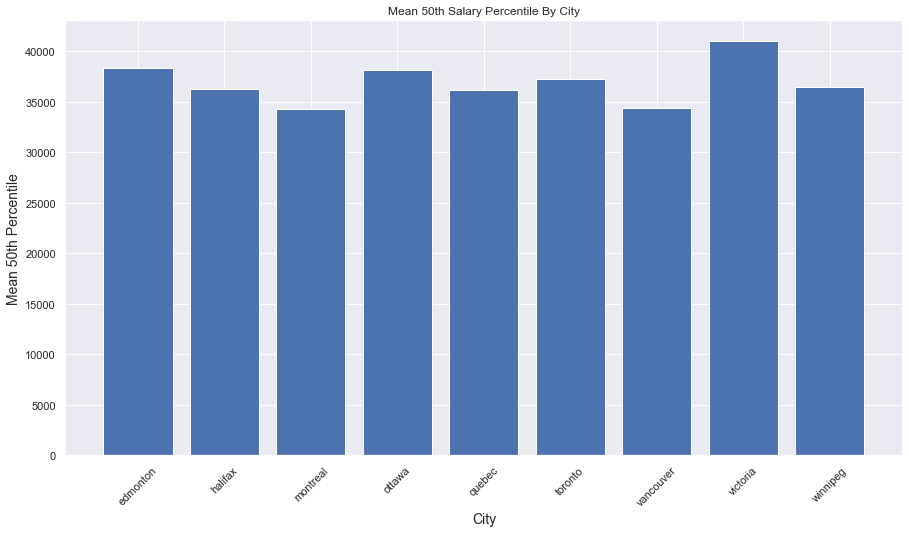

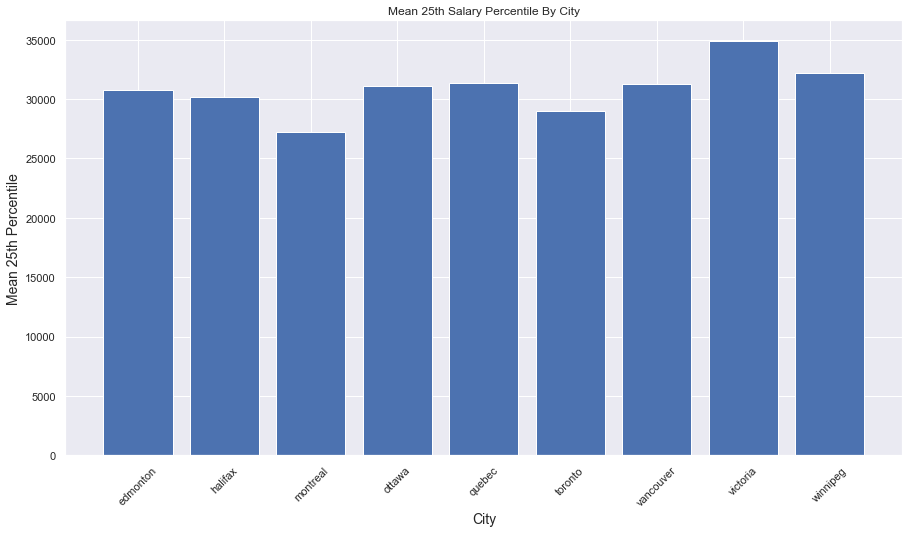

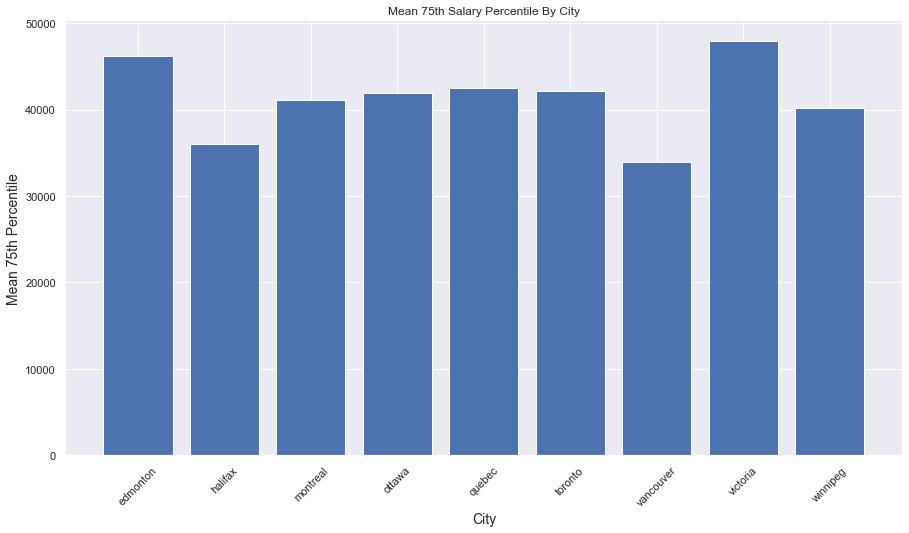

In [21]:
#50th Percentile
plt.bar(mean_salary_city['City'],mean_salary_city['percentile_50'])
plt.title('Mean 50th Salary Percentile By City')
plt.xlabel('City',fontsize = 14)
plt.xticks(rotation = 45)
plt.ylabel('Mean 50th Percentile', fontsize = 14)
plt.grid(True)
plt.show()

#25th Percentile
plt.bar(mean_salary_city['City'],mean_salary_city['percentile_25'])
plt.title('Mean 25th Salary Percentile By City')
plt.xlabel('City',fontsize = 14)
plt.xticks(rotation = 45)
plt.ylabel('Mean 25th Percentile', fontsize = 14)
plt.grid(True)
plt.show()

#75th Percentile
plt.bar(mean_salary_city['City'],mean_salary_city['percentile_75'])
plt.title('Mean 75th Salary Percentile By City')
plt.xlabel('City',fontsize = 14)
plt.xticks(rotation = 45)
plt.ylabel('Mean 75th Percentile', fontsize = 14)
plt.grid(True)
plt.show()

# I would like to highlight the highest and lowest values in each plot.

Based on the above visualizations, we can see that Victoria has the highest mean salary across all career positions. 
Montreal had the lowest mean 25th percentile and 50th percentiles while vancouver had the lowest mean 75th percentile.
We also see the highest disparity between cities in the 75th percentile graph.

Some details are difficult to perceive through the bar graph. Let's try a boxplot instead.

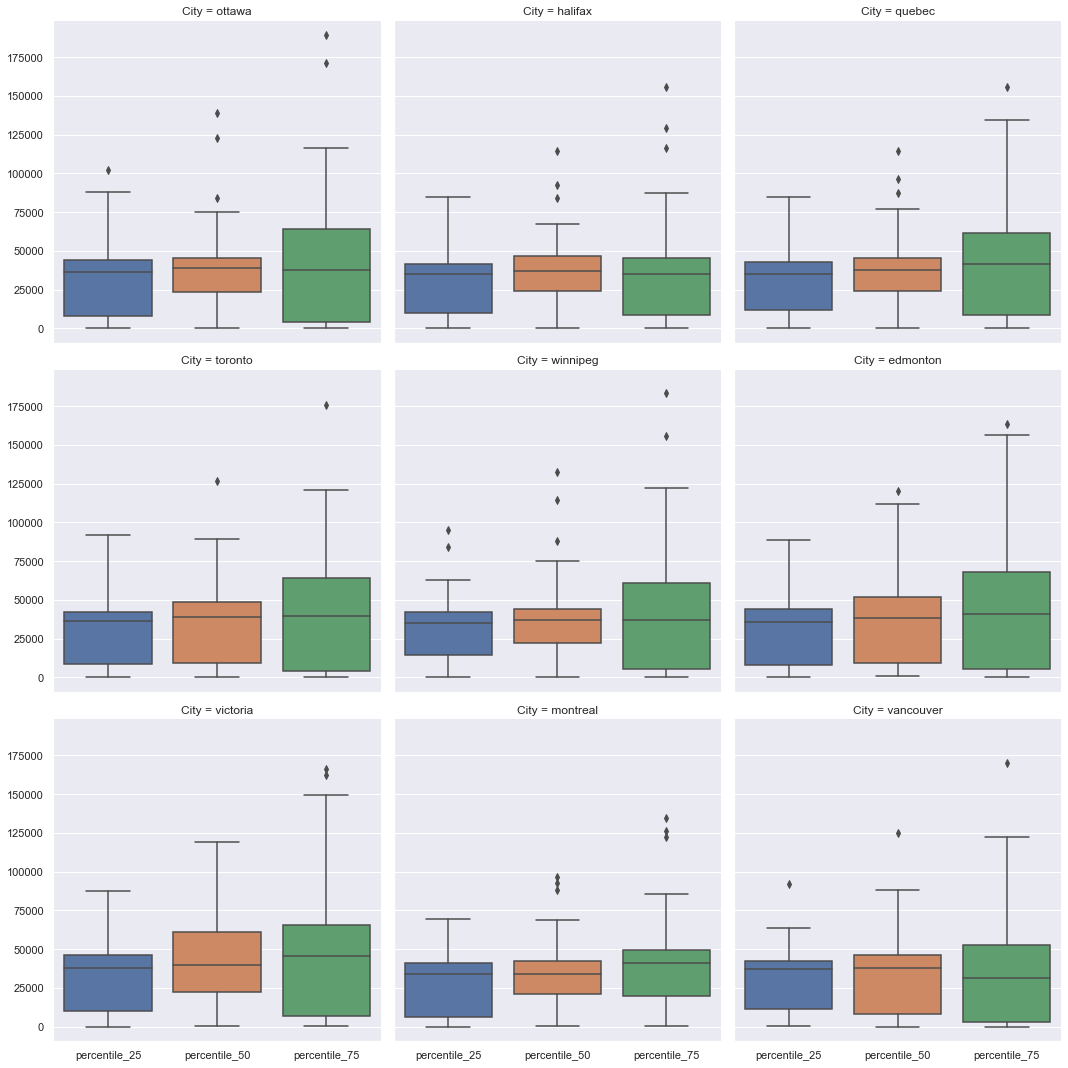

In [22]:
sns.catplot(col = 'City',data = raw_salaries_preprocessed,kind = 'box',col_wrap = 3)

A few interesting observations:
- The median values for each percentile are extremely similar across all cities hovering around the 40-50k mark
- Ottawa, Toronto, and Winnipeg all have professions where the 75th percentile sits above 175k / year
- There are professions in all cities that dip below minimum wage (around 25k / year) across all percentiles 

In [23]:
raw_salaries_preprocessed.describe()

,percentile_25,percentile_50,percentile_75
count,468.000000,468.000000,468.000000
mean,30881.227372,36938.969038,41331.708632
std,20360.348385,26169.866879,36999.981805
min,3.460000,0.400000,32.770000
25%,8843.430000,20428.875000,4740.545000
50%,35953.185000,37607.770000,39942.725000
75%,42724.087500,46893.210000,62461.122500
max,102303.560000,139050.870000,188997.770000


A few more questions from the above summary:
- The minimum values appear to be useless (data entry errors), but I'm curious where they are being reported and for which professiion.
- What jobs report the highest 25th,50th,and 75th percentiles and in which city?

In [24]:
min_df = pd.DataFrame()
min_25 = raw_salaries_preprocessed[raw_salaries_preprocessed['percentile_25'] == raw_salaries_preprocessed.describe().loc['min'].percentile_25]
min_50 = raw_salaries_preprocessed[raw_salaries_preprocessed['percentile_50'] == raw_salaries_preprocessed.describe().loc['min'].percentile_50]
min_75 = raw_salaries_preprocessed[raw_salaries_preprocessed['percentile_75'] == raw_salaries_preprocessed.describe().loc['min'].percentile_75]
min_df = pd.concat([min_25,min_50,min_75])
min_df

,City,job_title,percentile_25,percentile_50,percentile_75
42,quebec,Receptionist,3.46,25296.23,28819.79
11,quebec,Civil Engineer,45325.68,0.40,68081.65
35,ottawa,Operations Manager,35815.64,45472.37,32.77


The returned minimum values appear to just be data entry errors with very little insight to offer.

In [25]:
max_df = pd.DataFrame()
max_25 = raw_salaries_preprocessed[raw_salaries_preprocessed['percentile_25'] == raw_salaries_preprocessed.describe().loc['max'].percentile_25]
max_50 = raw_salaries_preprocessed[raw_salaries_preprocessed['percentile_50'] == raw_salaries_preprocessed.describe().loc['max'].percentile_50]
max_75 = raw_salaries_preprocessed[raw_salaries_preprocessed['percentile_75'] == raw_salaries_preprocessed.describe().loc['max'].percentile_75]
max_df = pd.concat([max_25,max_50,max_75])
max_df

,City,job_title,percentile_25,percentile_50,percentile_75
37,ottawa,Physician,102303.56,139050.87,188997.77
37,ottawa,Physician,102303.56,139050.87,188997.77
37,ottawa,Physician,102303.56,139050.87,188997.77


Being a Physician in Ottawa offers the highest 25th, 50th, and 75th salary percentile across all Canadian cities.

## Examining Quality of Life Scores

A few preliminary questions to get started:
- Which cities have the highest and lowest scores in each category?
- Do scores in one category have interesting correlations with scores in another category?

In [26]:
raw_score_preprocessed

,City,name,score_out_of_10
0,ottawa,Housing,6.70
1,ottawa,Cost of Living,6.03
2,ottawa,Startups,6.06
3,ottawa,Venture Capital,2.61
4,ottawa,Travel Connectivity,1.53
...,...,...,...
12,vancouver,Taxation,7.27
13,vancouver,Internet Access,4.55
14,vancouver,Leisure & Culture,5.72
15,vancouver,Tolerance,8.30


I'll start by putting the data into a more readable format using a pivot table.

In [27]:
score_pivot = raw_score_preprocessed.pivot(index = 'City', columns = 'name', values = 'score_out_of_10')
score_pivot = score_pivot.reset_index()
score_pivot

name,City,Business Freedom,Commute,Cost of Living,Economy,Education,Environmental Quality,Healthcare,Housing,Internet Access,Leisure & Culture,Outdoors,Safety,Startups,Taxation,Tolerance,Travel Connectivity,Venture Capital
0,edmonton,8.97,5.10,5.52,5.84,5.95,8.18,8.93,6.73,4.61,3.97,3.38,7.12,4.62,7.27,7.93,1.90,2.39
1,halifax,8.97,5.40,4.94,5.84,5.42,7.62,8.67,6.90,6.12,3.94,4.02,7.19,3.62,7.27,7.85,1.57,2.28
2,montreal,8.97,5.11,5.95,5.84,7.30,7.72,8.33,7.39,4.48,6.92,5.30,7.82,8.10,7.27,8.19,3.44,5.77
3,ottawa,8.97,5.41,6.03,5.84,5.42,9.29,8.88,6.70,6.27,6.09,5.32,8.45,6.06,7.27,8.63,1.53,2.61
4,quebec,8.97,5.28,6.04,5.84,5.42,7.32,8.73,8.52,3.30,5.64,4.72,9.16,3.73,7.27,8.62,1.38,2.24
5,toronto,8.97,4.68,5.27,5.84,7.60,7.18,8.77,4.66,4.38,7.83,5.59,7.69,9.98,7.27,7.93,4.34,7.60
6,vancouver,8.97,4.94,5.26,5.84,6.89,8.42,8.75,4.08,4.55,5.72,7.40,7.57,8.17,7.27,8.30,2.77,5.84
7,victoria,8.97,5.23,5.70,5.84,5.38,9.29,8.52,5.70,6.19,4.52,4.36,7.81,4.48,7.27,8.78,1.49,2.72
8,winnipeg,8.97,5.10,5.88,5.84,5.34,5.67,8.54,7.55,4.90,4.69,4.24,6.02,3.80,7.27,6.66,1.48,0.00


Next, I can create a correlation matrix to see how quality of life scores correlate with each other.

In [28]:
#Since Business Freedom, Economy, and Taxation are identical across all cities, they are not suitable candidates for the corr matrix
score_pivot_2 = score_pivot.drop(['City','Economy','Business Freedom','Taxation'],axis = 1)
corr_matrix = score_pivot_2.corr()
corr_matrix

name,Commute,Cost of Living,Education,Environmental Quality,Healthcare,Housing,Internet Access,Leisure & Culture,Outdoors,Safety,Startups,Tolerance,Travel Connectivity,Venture Capital
name,,,,,,,,,,,,,,
Commute,1.000000,0.297353,-0.804919,0.316791,-0.015227,0.620469,0.490260,-0.561478,-0.433169,0.248773,-0.745907,0.265578,-0.825149,-0.693426
Cost of Living,0.297353,1.000000,-0.258597,0.007288,-0.228369,0.591038,-0.199605,0.189322,-0.102203,0.356566,-0.180071,0.158462,-0.281845,-0.325540
Education,-0.804919,-0.258597,1.000000,-0.072413,-0.149599,-0.539054,-0.415616,0.759435,0.585641,0.022506,0.933102,0.020612,0.978612,0.932383
Environmental Quality,0.316791,0.007288,-0.072413,1.000000,0.262200,-0.352361,0.494298,-0.052897,0.187621,0.503899,0.107829,0.839825,-0.125959,0.191128
Healthcare,-0.015227,-0.228369,-0.149599,0.262200,1.000000,-0.219560,-0.013989,-0.120714,-0.011501,0.187865,-0.027000,0.157576,-0.143338,-0.042532
Housing,0.620469,0.591038,-0.539054,-0.352361,-0.219560,1.000000,-0.184429,-0.277468,-0.618849,0.134402,-0.659922,-0.156084,-0.538625,-0.654875
Internet Access,0.490260,-0.199605,-0.415616,0.494298,-0.013989,-0.184429,1.000000,-0.371279,-0.199590,-0.223505,-0.227568,0.096254,-0.353217,-0.273675
Leisure & Culture,-0.561478,0.189322,0.759435,-0.052897,-0.120714,-0.277468,-0.371279,1.000000,0.619040,0.394978,0.853514,0.192498,0.799091,0.778100
Outdoors,-0.433169,-0.102203,0.585641,0.187621,-0.011501,-0.618849,-0.199590,0.619040,1.000000,0.264206,0.723177,0.270179,0.515894,0.671288


<AxesSubplot:xlabel='name', ylabel='name'>

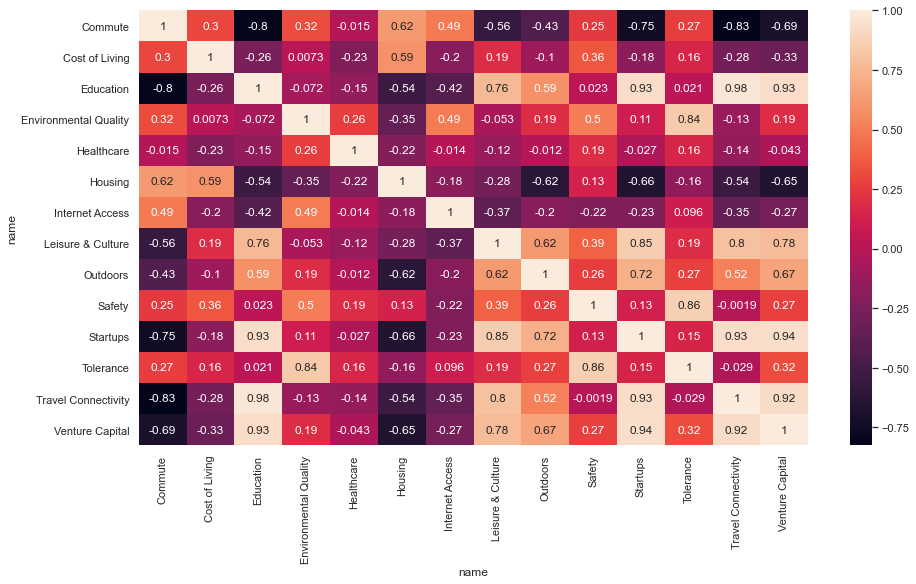

In [29]:
sns.heatmap(corr_matrix,annot = True)

Some interesting correlations to observe that I wouldn't have immediately thought of before seeing these results:
- Education is very negatively correlated with commute. In fact, commute seems to be negatively correlated with every Business metric
- Travel Connectivity is very positively correlated with startup/VC presence as well with Leisure & Culture.
- Startups seem to be moderately positvely correlated with a higher Outdoors rating.
- Internet Access does not appear to be highly correlated with any of the other scores. This could be because Internet access is fairly even across Canada.
    - It would be interesting to see how Internet Access correlates with other quality of life metrics in countries/provinces/states where there is uneven access to Internet.


In [30]:
score_pivot.describe()

name,Business Freedom,Commute,Cost of Living,Economy,Education,Environmental Quality,Healthcare,Housing,Internet Access,Leisure & Culture,Outdoors,Safety,Startups,Taxation,Tolerance,Travel Connectivity,Venture Capital
count,9.00,9.000000,9.000000,9.00,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000e+00,9.000000,9.000000,9.000000
mean,8.97,5.138889,5.621111,5.84,6.080000,7.854444,8.680000,6.470000,4.977778,5.480000,4.925556,7.647778,5.840000,7.270000e+00,8.098889,2.211111,3.494444
std,0.00,0.230187,0.395583,0.00,0.923052,1.125434,0.189011,1.418705,1.011704,1.334579,1.167316,0.875497,2.361266,1.884111e-15,0.637935,1.064876,2.382142
min,8.97,4.680000,4.940000,5.84,5.340000,5.670000,8.330000,4.080000,3.300000,3.940000,3.380000,6.020000,3.620000,7.270000e+00,6.660000,1.380000,0.000000
25%,8.97,5.100000,5.270000,5.84,5.420000,7.320000,8.540000,5.700000,4.480000,4.520000,4.240000,7.190000,3.800000,7.270000e+00,7.930000,1.490000,2.280000
50%,8.97,5.110000,5.700000,5.84,5.420000,7.720000,8.730000,6.730000,4.610000,5.640000,4.720000,7.690000,4.620000,7.270000e+00,8.190000,1.570000,2.610000
75%,8.97,5.280000,5.950000,5.84,6.890000,8.420000,8.770000,7.390000,6.120000,6.090000,5.320000,7.820000,8.100000,7.270000e+00,8.620000,2.770000,5.770000
max,8.97,5.410000,6.040000,5.84,7.600000,9.290000,8.930000,8.520000,6.270000,7.830000,7.400000,9.160000,9.980000,7.270000e+00,8.780000,4.340000,7.600000


Next: for each metric, which city has the best scores?

We can answer this question by identifying which column (city) in the pivot table has the highest score for each quality of life metric.

In [31]:
max_cols = pd.DataFrame(score_pivot[['Commute', 'Cost of Living',
       'Education', 'Environmental Quality', 'Healthcare', 'Housing',
       'Internet Access', 'Leisure & Culture', 'Outdoors', 'Safety',
       'Startups','Tolerance', 'Travel Connectivity',
       'Venture Capital']].idxmax(axis=0))

max_cols['row'] = max_cols[0]
max_cols_fixed = pd.DataFrame(max_cols['row'])
max_cols_fixed

# Does not take into account, tied scores - is there any way to provide a list of cities?

,row
name,
Commute,3
Cost of Living,4
Education,5
Environmental Quality,3
Healthcare,0
Housing,4
Internet Access,3
Leisure & Culture,5
Outdoors,6


In [32]:
best_city = score_pivot.merge(max_cols_fixed,left_index = True,right_on = 'row') 
best_city.rename(columns = {'City':'Recommended City'},inplace = True)
best_city = best_city.drop(['row','Business Freedom','Economy',"Taxation"],axis = 1)
best_city

,Recommended City,Commute,Cost of Living,Education,Environmental Quality,Healthcare,Housing,Internet Access,Leisure & Culture,Outdoors,Safety,Startups,Tolerance,Travel Connectivity,Venture Capital
name,,,,,,,,,,,,,,,
Healthcare,edmonton,5.10,5.52,5.95,8.18,8.93,6.73,4.61,3.97,3.38,7.12,4.62,7.93,1.90,2.39
Commute,ottawa,5.41,6.03,5.42,9.29,8.88,6.70,6.27,6.09,5.32,8.45,6.06,8.63,1.53,2.61
Environmental Quality,ottawa,5.41,6.03,5.42,9.29,8.88,6.70,6.27,6.09,5.32,8.45,6.06,8.63,1.53,2.61
Internet Access,ottawa,5.41,6.03,5.42,9.29,8.88,6.70,6.27,6.09,5.32,8.45,6.06,8.63,1.53,2.61
Cost of Living,quebec,5.28,6.04,5.42,7.32,8.73,8.52,3.30,5.64,4.72,9.16,3.73,8.62,1.38,2.24
Housing,quebec,5.28,6.04,5.42,7.32,8.73,8.52,3.30,5.64,4.72,9.16,3.73,8.62,1.38,2.24
Safety,quebec,5.28,6.04,5.42,7.32,8.73,8.52,3.30,5.64,4.72,9.16,3.73,8.62,1.38,2.24
Education,toronto,4.68,5.27,7.60,7.18,8.77,4.66,4.38,7.83,5.59,7.69,9.98,7.93,4.34,7.60
Leisure & Culture,toronto,4.68,5.27,7.60,7.18,8.77,4.66,4.38,7.83,5.59,7.69,9.98,7.93,4.34,7.60


Above we see recommendations for best cities to live in for each category (some categories had mutliple cities with the highest score, but I have kept the data in this format for the purpose of presentation). It seems that Toronto is the most highly recommended city (top scores in 5 categories) followed by Ottawa and Quebec City (each with three top scores).

Next, what is the best feature of each city?

In [33]:
score_pivot_reduced = score_pivot.drop(['Business Freedom','Economy',"Taxation"],axis = 1)
best_feature = pd.DataFrame(score_pivot_reduced.where(score_pivot_reduced.eq(score_pivot_reduced.max(1),axis = 0)).stack())
best_feature = best_feature.reset_index()
best_feature = score_pivot.merge(best_feature,left_index = True,right_index= True)
best_feature = best_feature.drop(best_feature.iloc[:,1:19],axis = 1)
best_feature.rename(columns = {'City':'city','name':'best_feature', 0:'score'},inplace = True)
best_feature

C:\Users\Nickf\AppData\Local\Temp/ipykernel_8492/3185780417.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  best_feature = pd.DataFrame(score_pivot_reduced.where(score_pivot_reduced.eq(score_pivot_reduced.max(1),axis = 0)).stack())


,city,best_feature,score
0,edmonton,Healthcare,8.93
1,halifax,Healthcare,8.67
2,montreal,Healthcare,8.33
3,ottawa,Environmental Quality,9.29
4,quebec,Safety,9.16
5,toronto,Startups,9.98
6,vancouver,Healthcare,8.75
7,victoria,Environmental Quality,9.29
8,winnipeg,Healthcare,8.54


- Healthcare is the highest rated category across 5 cities, a testament to Canada's universal healthcare system.
- Unsurprisingly, Toronto is the king of Startups as the largest metropolitan centre in Canada.
- Rather surprising: Quebec City's top category is Safety. I wonder what makes it different? This could be answered later through the raw_details data frame.

Finally, what is the most poorly scoring category for each Canadian city?

In [34]:
worst_feature = pd.DataFrame(score_pivot_reduced.where(score_pivot_reduced.eq(score_pivot_reduced.min(1),axis = 0)).stack())
worst_feature = worst_feature.reset_index()
worst_feature = score_pivot.merge(worst_feature,left_index = True,right_index= True)
worst_feature = worst_feature.drop(worst_feature.iloc[:,1:19],axis = 1)
worst_feature.rename(columns = {'City':'city','name':'worst_feature', 0:'score'},inplace = True)
worst_feature

C:\Users\Nickf\AppData\Local\Temp/ipykernel_8492/1691910996.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  worst_feature = pd.DataFrame(score_pivot_reduced.where(score_pivot_reduced.eq(score_pivot_reduced.min(1),axis = 0)).stack())


,city,worst_feature,score
0,edmonton,Travel Connectivity,1.9
1,halifax,Travel Connectivity,1.57
2,montreal,Travel Connectivity,3.44
3,ottawa,Travel Connectivity,1.53
4,quebec,Travel Connectivity,1.38
5,toronto,Travel Connectivity,4.34
6,vancouver,Travel Connectivity,2.77
7,victoria,Travel Connectivity,1.49
8,winnipeg,Venture Capital,0.0


- The data does not lie: the worst feature across all of Canada is Travel Connectivity.
- Surprisingly, Winnipeg was rated 0 for Venture Capital. Is there really no VC presence in Winnipeg,MB?

### And finally, to see the overall ranking of cities in terms of these quality of life scores:

In [35]:
score_pivot['mean_score'] = score_pivot.iloc[:,1:-1].mean(axis = 1)
score_pivot

name,City,Business Freedom,Commute,Cost of Living,Economy,Education,Environmental Quality,Healthcare,Housing,Internet Access,Leisure & Culture,Outdoors,Safety,Startups,Taxation,Tolerance,Travel Connectivity,Venture Capital,mean_score
0,edmonton,8.97,5.10,5.52,5.84,5.95,8.18,8.93,6.73,4.61,3.97,3.38,7.12,4.62,7.27,7.93,1.90,2.39,6.001250
1,halifax,8.97,5.40,4.94,5.84,5.42,7.62,8.67,6.90,6.12,3.94,4.02,7.19,3.62,7.27,7.85,1.57,2.28,5.958750
2,montreal,8.97,5.11,5.95,5.84,7.30,7.72,8.33,7.39,4.48,6.92,5.30,7.82,8.10,7.27,8.19,3.44,5.77,6.758125
3,ottawa,8.97,5.41,6.03,5.84,5.42,9.29,8.88,6.70,6.27,6.09,5.32,8.45,6.06,7.27,8.63,1.53,2.61,6.635000
4,quebec,8.97,5.28,6.04,5.84,5.42,7.32,8.73,8.52,3.30,5.64,4.72,9.16,3.73,7.27,8.62,1.38,2.24,6.246250
5,toronto,8.97,4.68,5.27,5.84,7.60,7.18,8.77,4.66,4.38,7.83,5.59,7.69,9.98,7.27,7.93,4.34,7.60,6.748750
6,vancouver,8.97,4.94,5.26,5.84,6.89,8.42,8.75,4.08,4.55,5.72,7.40,7.57,8.17,7.27,8.30,2.77,5.84,6.556250
7,victoria,8.97,5.23,5.70,5.84,5.38,9.29,8.52,5.70,6.19,4.52,4.36,7.81,4.48,7.27,8.78,1.49,2.72,6.220625
8,winnipeg,8.97,5.10,5.88,5.84,5.34,5.67,8.54,7.55,4.90,4.69,4.24,6.02,3.80,7.27,6.66,1.48,0.00,5.746875


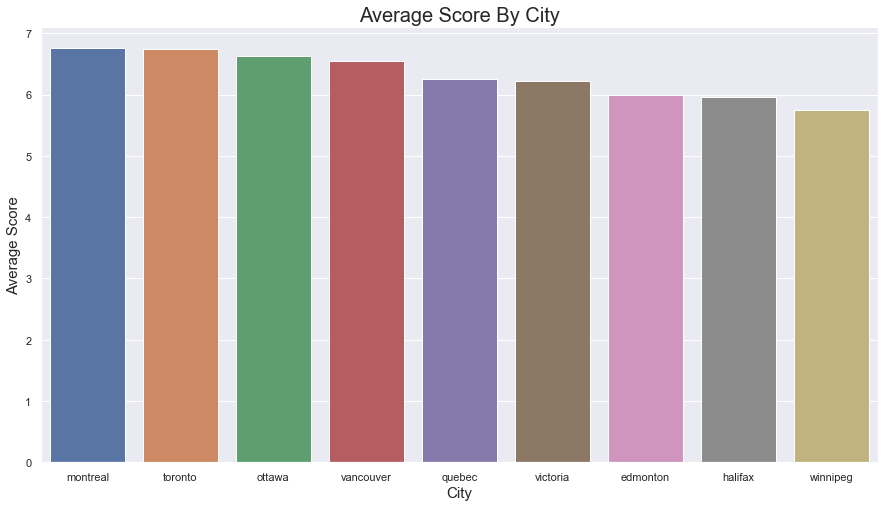

In [36]:
sns.barplot(x = 'City', y = 'mean_score',data = score_pivot,
           order = score_pivot.sort_values('mean_score',ascending = False).City)
plt.xlabel('City', size = 15)
plt.ylabel('Average Score', size = 15)
plt.title('Average Score By City', size = 20)
plt.show()

# Using More Granular Metrics to Dig Deeper

In [37]:
raw_details_preprocessed.describe(include = 'all')

,City,float_value,id,label,type,percent_value,string_value,currency_dollar_value,int_value,url_value
count,1356,657.000000,1356,1356,1356,139.000000,144,152.000000,258.000000,6
unique,9,NaN,155,155,6,NaN,37,NaN,NaN,6
top,vancouver,NaN,BUSINESS-FREEDOM,Business freedom,float,NaN,✔ Legal,NaN,NaN,http://cities.human.co/details/Canada/Ottawa
freq,154,NaN,9,9,657,NaN,27,NaN,NaN,1
mean,NaN,102.167448,NaN,NaN,NaN,0.188447,NaN,5602.658408,2859.414457,NaN
std,NaN,577.040711,NaN,NaN,NaN,0.249687,NaN,15379.466694,22310.736757,NaN
min,NaN,0.100000,NaN,NaN,NaN,0.000710,NaN,0.760000,1.000000,NaN
25%,NaN,0.594800,NaN,NaN,NaN,0.026320,NaN,7.925000,9.000000,NaN
50%,NaN,0.843200,NaN,NaN,NaN,0.108948,NaN,62.530000,44.500000,NaN
75%,NaN,9.480000,NaN,NaN,NaN,0.163959,NaN,855.000000,125.500000,NaN


At first glance, this data looks a little more complex to analyze than the other tables. I'll start by looking through the 155 unique labels and will formulate a handful of questions from those.

In [38]:
print(raw_details_preprocessed['label'].unique())

['Business freedom' 'Business freedom [Teleport score]'
 'Freedom from corruption' 'Freedom from corruption [Teleport score]'
 'Lack of labor restrictions'
 'Lack of labor restrictions [Teleport score]' 'Time to open a business'
 'Time to open a business [Teleport score]'
 'Urban area population (millions)'
 'Population density in people/sq km in UA center.'
 'Population density in people/sq km over full UA as defined by bounding box.'
 'Average day length (hours)' 'Average number of rainy days per year'
 'Average annual percent chance of sunshine'
 'Average high temperature (Celsius)' 'Average low temperature (Celsius)'
 'Average daily solar radiation (Mj/m²)' 'Weather type'
 'Inflation [Teleport score]' 'A kilogram of Apples' 'Bread'
 'A Cappuccino' 'Movie ticket' 'Monthly fitness club membership' 'A beer'
 'Monthly public transport' 'Lunch' '5km taxi ride'
 'Price of a meal at a restaurant' 'Art galleries [Teleport score]'
 'Art galleries' 'Cinemas [Teleport score]' 'Cinemas'
 'Come

A good place to start might be to work on answering a handful of questions I had related to the insights gained through the scoring data. These are:
- What contributes to Quebec City's high safety score? What makes it different in comparison to other cities?
- What factors explain Winnipeg's abysmal 0.00 score in venture capital?
- Are there any standout influencers on Canada's negative transportation score?

For Quebec safety, I'll start by looking at the following labels:
- Crime Rate
- Lack of Gun Related Deaths
- Lack of Guns
- Lack of Guns and Gun-Related Deaths
- Gun-related deaths per 100,000 residents per year
- Guns per 100 residents

For VC, I'll look at:
- Coworking spaces [Teleport score]' 
- 'Startup events'
- 'Number of startup events in the last 12 months'
- 'Startup events [Teleport score]' 
- 'Total number of startups'
- 'Number of upcoming meetup events' 
- 'Meetups groups' 
- 'Meetups members'
- 'Meetups [Teleport score]' 
- 'Number of investors'
- 'Average monthly increase in number of startups'
- 'Average monthly increase in number of startups [Teleport score]'
- 'Startup climate scene [Teleport score]' 
- 'Startups [Teleport score]'
- 'Coworking spaces on WorkFrom.co'

For Transport:
- 'Traffic handling [Teleport score]' 'Airport hub'
- 'Airport hub [Teleport score]'
- 'Intercity train connectivity [Teleport score]' 
- 'Seaside access'
- 'Presence of mountains in city'

## Safety:

In [39]:
#Building the dataframe
safety_labels = np.array(['Crime rate [Teleport score]',
 'Gun-related deaths per 100,000 residents per year',
 'Lack of gun related deaths [Teleport score]', 'Guns per 100 residents',
 'Lack of guns [Teleport score]',
 'Lack of guns and gun-related deaths [Teleport score]'])

safety_details = raw_details_preprocessed.copy()
safety_details['safetyYN'] = np.isin(element = safety_details['label'],test_elements = safety_labels)
safety_df = safety_details[safety_details['safetyYN'] == True]
safety_df['float_value'] = safety_df['float_value'].fillna(0)
safety_df['int_value'] = safety_df['int_value'].fillna(0)
safety_df['score'] = safety_df['float_value'] + safety_df['int_value']
safety_df = safety_df.drop(['float_value', 'id','type', 'percent_value',
       'string_value', 'currency_dollar_value', 'int_value', 'url_value',
       'safetyYN'],axis = 1)
safety_df.reset_index(drop = True,inplace = True)

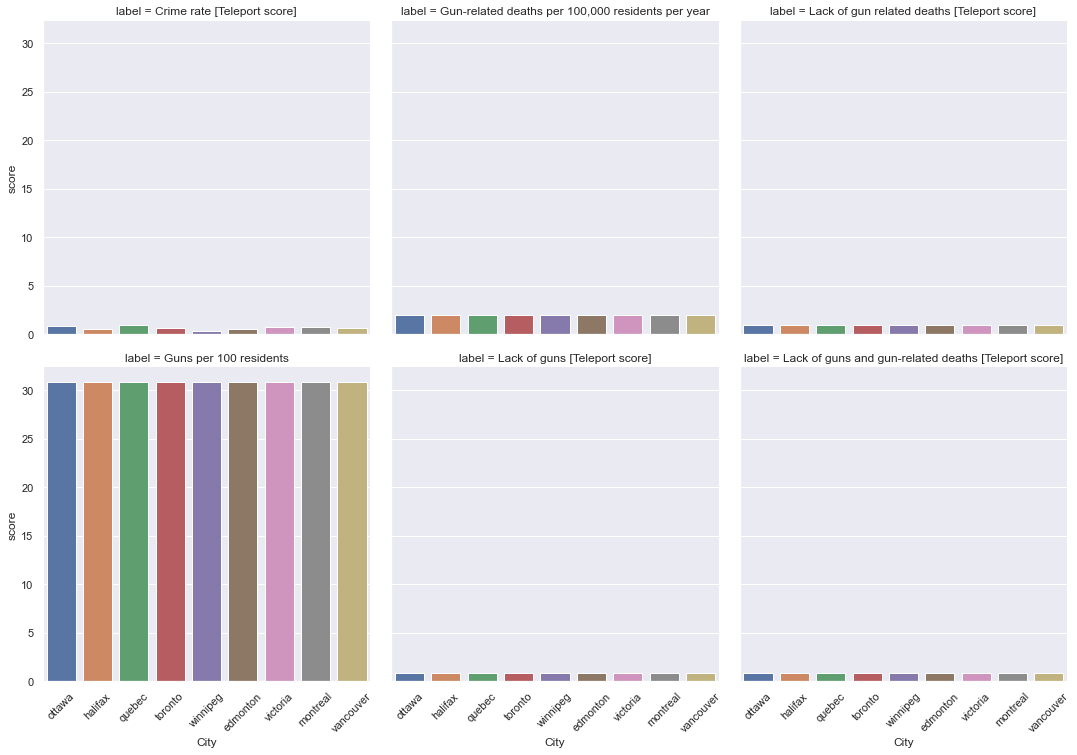

In [40]:
safety_plt = sns.catplot(x = 'City', y = 'score', col = 'label', data = safety_df, kind = 'bar', col_wrap = 3)
safety_plt.set_xticklabels(rotation=45)
plt.show()

Unfortunately, the data doesn't provide any insight on this particular questions as the values are exactly the same for every city. I confirmed that this was not an issue caused by how I imported the data but rather how it is presented on www.teleport.org. I'm not sure why this is the case but I'm assuming that the city-by-city stats were missing and so a national figure was used?

From a quick google search, Quebec City is known as being one of the safest metropolitan cities in the world. It has the lowest crime severity index of any city in Canada. The crime severity index is defined as follows:

The Crime Severity Index (CSI) takes into account both the volume and the seriousness of crime. In the calculation of the CSI, each offence is assigned a weight, derived from average sentences handed down by criminal courts. The more serious the average sentence, the higher the weight for that offence. As a result, more serious offences have a greater impact on changes in the index. All police-reported Criminal Code offences are included in the CSI.
- https://www.statista.com/statistics/525603/crime-severity-index-in-canada/

While it's unfortunate that this answer could not be provided by the data, at least it led to some further investigation.

## VC: 

www.teleport.org tells us that the only VC indicator used for the VC score is 'Number of funding accelerators'.

A funding accelerator is an organization who offers seed money to startups to allow them to stabilize and become self-sufficient, usually in exchange for equity in the company.

In [41]:
raw_details_preprocessed[raw_details_preprocessed['id'].str.contains('Funding|Accel', flags=re.IGNORECASE, regex=True)]

,City,float_value,id,label,type,percent_value,string_value,currency_dollar_value,int_value,url_value


Unfortunately, it does not appear that this data was pulled in the API call. However, here is an example of the data:

**City: Montreal**

**Funding accelerator names	FounderFuel**

**Number of funding accelerators	1**

**Venture capital [score]	0.58**

The explanation for Winnipeg's 0 score in VC is that they have no funding accelerators and so the score was N/A.

## Transport: 

In [42]:
#Building the dataframe
transport_labels = np.array(['Traffic handling [Teleport score]', 'Airport hub',
 'Airport hub [Teleport score]',
 'Intercity train connectivity [Teleport score]', 'Seaside access',
 'Presence of mountains in city'])

transport_details = raw_details_preprocessed.copy()
transport_details['transportYN'] = np.isin(element = transport_details['label'],test_elements = transport_labels)
transport_df = transport_details[transport_details['transportYN'] == True]
transport_df['float_value'] = transport_df['float_value'].fillna(0)
transport_df['int_value'] = transport_df['int_value'].fillna(0)
transport_df['score'] = transport_df['float_value'] + transport_df['int_value']
transport_df = transport_df.drop(['float_value', 'id','type', 'percent_value',
       'string_value', 'currency_dollar_value', 'int_value', 'url_value',
       'transportYN'],axis = 1)
transport_df.reset_index(drop = True,inplace = True)
transport_df.head()

,City,label,score
0,ottawa,Traffic handling [Teleport score],0.7387
1,ottawa,Airport hub,26.0000
2,ottawa,Airport hub [Teleport score],0.1893
3,ottawa,Intercity train connectivity [Teleport score],0.1171
4,halifax,Seaside access,1.0000


To provide a bit of an explanation for Canada's abysmal travel connectivity performance. I want to compare it to a recognized benchmark. London, England is one of my favourite cities in the world and received a travel connectivity score of 10/10. How does it compare in the above categories? Is it just its metro system that skyrockets its score?

In [43]:
london_data = pull_details(['london'])
london_data.head()

,City,float_value,id,label,type,string_value,currency_dollar_value,int_value,percent_value,url_value
0,london,86.0,BUSINESS-FREEDOM,Business freedom,float,NaN,NaN,NaN,NaN,NaN
1,london,0.889,BUSINESS-FREEDOM-TELESCORE,Business freedom [Teleport score],float,NaN,NaN,NaN,NaN,NaN
2,london,78.0,CORRUPTION-FREEDOM,Freedom from corruption,float,NaN,NaN,NaN,NaN,NaN
3,london,0.8447,CORRUPTION-FREEDOM-TELESCORE,Freedom from corruption [Teleport score],float,NaN,NaN,NaN,NaN,NaN
4,london,71.8,LABOR-RESTRICTIONS,Lack of labor restrictions,float,NaN,NaN,NaN,NaN,NaN


In [44]:
london_details = london_data.copy()
london_details['transportYN'] = np.isin(element = london_details['label'],test_elements = transport_labels)
london_df = london_details[london_details['transportYN'] == True]
london_df['float_value'] = london_df['float_value'].fillna(0)
london_df['int_value'] = london_df['int_value'].fillna(0)
london_df['score'] = london_df['float_value'] + london_df['int_value']
london_df = london_df.drop(['float_value', 'id','type', 'percent_value',
       'string_value', 'currency_dollar_value', 'int_value', 'url_value',
       'transportYN'],axis = 1)
london_df.reset_index(drop = True,inplace = True)
london_df

,City,label,score
0,london,Traffic handling [Teleport score],0.5406
1,london,Airport hub,357.0000
2,london,Airport hub [Teleport score],1.0000
3,london,Intercity train connectivity [Teleport score],0.8805


In [45]:
transport_df = transport_df.append(london_df)
transport_df.reset_index(drop=True, inplace = True)
transport_df.tail()

,City,label,score
41,vancouver,Intercity train connectivity [Teleport score],0.1387
42,london,Traffic handling [Teleport score],0.5406
43,london,Airport hub,357.0000
44,london,Airport hub [Teleport score],1.0000
45,london,Intercity train connectivity [Teleport score],0.8805


In [46]:
transport_df[transport_df['City'] == 'london']['label'].values

array(['Traffic handling [Teleport score]', 'Airport hub',
       'Airport hub [Teleport score]',
       'Intercity train connectivity [Teleport score]'], dtype=object)

In [47]:
#To get only the transport categories held by London
london_labels = np.array(['Traffic handling [Teleport score]',
       'Airport hub [Teleport score]',
       'Intercity train connectivity [Teleport score]'])
transport_df['londonYN'] = np.isin(element = transport_df['label'],test_elements = london_labels)
transport_df = transport_df[transport_df['londonYN'] == True]
transport_df = transport_df.drop(['londonYN'], axis = 1)
transport_df

,City,label,score
0,ottawa,Traffic handling [Teleport score],0.7387
2,ottawa,Airport hub [Teleport score],0.1893
3,ottawa,Intercity train connectivity [Teleport score],0.1171
5,halifax,Traffic handling [Teleport score],0.7703
7,halifax,Airport hub [Teleport score],0.1969
8,halifax,Intercity train connectivity [Teleport score],0.1171
11,quebec,Traffic handling [Teleport score],0.8046
13,quebec,Airport hub [Teleport score],0.1592
14,quebec,Intercity train connectivity [Teleport score],0.1171
15,toronto,Traffic handling [Teleport score],0.4948


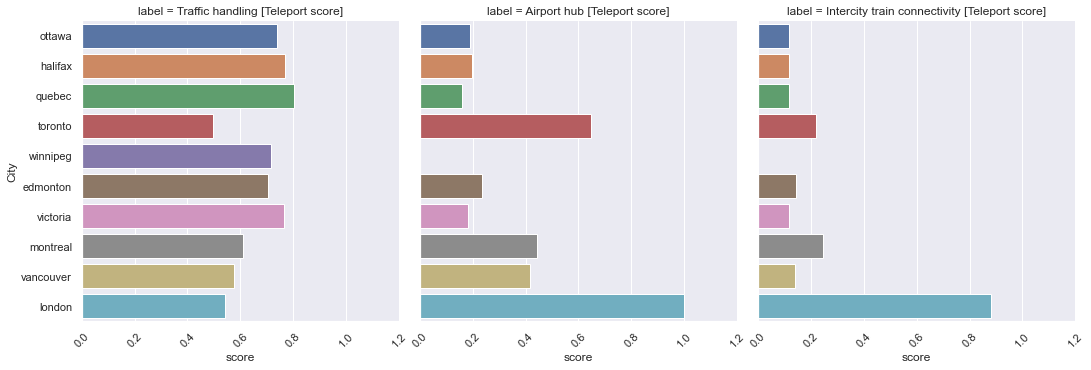

In [49]:
transport_plt = sns.catplot(x = 'score', y = 'City', col = 'label', data  = transport_df, kind ='bar')
transport_plt.set_xticklabels(rotation=45)
transport_plt

Key takeaways:
- London actually scores worse on traffic handling than every Canadian city other than Toronto.
- London absolutely destroys Canadian cities on Airport Hub and Intercity Train connectivity scores. 
- It is only slightly rivaled by Toronto and Montreal, as Pearson International is a major international airport and the Toronto & Montreal metros are the most robust in Canada.